In [1]:
import pandas as pd
import numpy as np
import os
import cv2

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

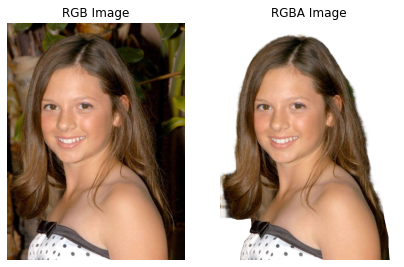

In [2]:
# set up the canvas for the subplots
plt.figure(figsize=(7,7))
plt.tight_layout()
plt.axis('Off')


# Our subplot will contain 4 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)

# image
plt.subplot(1,2,1)
path = '../input/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000000/1803151818-00000003.jpg'
image = plt.imread(path)
plt.title('RGB Image')
plt.imshow(image)
plt.axis('off')


# image
plt.subplot(1,2,2)
path = '../input/aisegmentcom-matting-human-datasets/matting/1803151818/matting_00000000/1803151818-00000003.png'
mask = plt.imread(path)
plt.title('RGBA Image')
plt.imshow(mask)
plt.axis('off')

plt.show()

<class 'numpy.ndarray'>


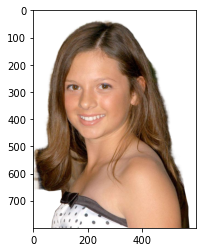

In [3]:
path = '../input/aisegmentcom-matting-human-datasets/clip_img/1803151818/clip_00000000/1803151818-00000003.jpg'

img=cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

f = np.zeros((800,600,4),np.uint8)
f[:,:,:3] = img

f[:,:,3] = mask[:,:,3]*255
plt.imshow(f)
print(type(f[:,:,3]))

In [4]:
p = list(f[:,:,3].flatten())
p.count(0)

149700

In [5]:
f[:,:,3].dtype

dtype('uint8')

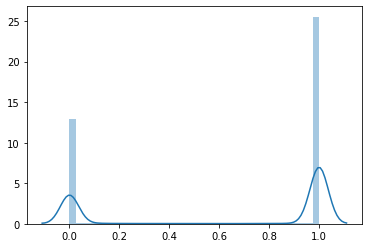

In [6]:
import seaborn as sns
sns.distplot(mask[:,:,3].flatten())

In [7]:
image.shape

(800, 600, 3)

In [8]:
(mask[:,:,3]).dtype

dtype('float32')

In [9]:
mask[:,:,3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
ana = list(mask[:,:,3].flatten())

In [11]:
len(ana)

480000

In [12]:
ana.count(0)+ana.count(1)

394447

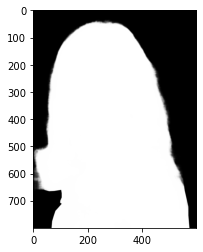

In [13]:
plt.imshow(mask[:,:,3],cmap = "gray") # 0 opaque 1 transparent

#                                        # * 1. 1. * MAIN PROGRAM STARTS****

In [14]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, Activation, Dense, Dropout,UpSampling2D,Conv2DTranspose
from keras import backend as K
import keras
import tensorflow as tf

In [15]:
c = pd.read_csv("../input/portraitsegmentation/mfinal.csv")

In [16]:
c.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'clip_paths', 'matted_paths'], dtype='object')

#                                                                           # TRAIN GENERATOR

In [17]:
def train_generator( df,batch_size=16, IMG_HEIGHT = 128, IMG_WIDTH = 128):
    
    
    while True:
        
        # load the data in chunks (batches)
        for  i in range(0,28000,16):
        
            X_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            Y_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float)
            
            for x in range(16):
                
                
                path = df["clip_paths"][x+i]
               
                image = cv2.imread(path)
                
                
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
              
                X_train[x] = image
            
#------------

                path = df["matted_paths"][x+i]

                # read the image
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

                # select the alpha channel
                k = mask[:, :, 3]
                
                
                
                k = np.expand_dims(k, axis=-1)
                
                # resize the mask
                k = resize(k, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                k = k>0.5
                # insert the image into Y_train
                Y_train[x] = k

            yield X_train, Y_train

# #VALIDTION GENERATOR

In [18]:
def val_generator( df1,batch_size=16, IMG_HEIGHT = 128, IMG_WIDTH = 128):
    
    IMG_CHANNELS = 3

    
    while True:
        
       
        for  i in range(28000,34000,16):
           
            
            
            X_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
            
            Y_train = np.zeros((batch_size, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float)


            for x in range(16):
                
               
                path = df1["clip_paths"][x+i]
                image = cv2.imread(path)
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
               
               
               
                X_train[x] = image
               
            # ===============
                
                path =  df1["matted_paths"][x+i]

               
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)

                
                k = mask[:, :, 3]
                k = np.expand_dims(k, axis=-1)
                k = resize(k, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                k = k>0.5
                
                Y_train[x] = k

            yield X_train, Y_train

# MODEL CODE

#  U-NET

def unet():

    inputs = Input((128,128,3))




    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
    return model

# SEGNET

In [19]:
def segnet():
    
    input1=Input((256,256,3))
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c1=BatchNormalization()(conv2)
    drop1 = Dropout(0.1)(c1)
    pool1 =MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv1=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c2=BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(c2)
    pool2 =MaxPooling2D(pool_size=(2, 2))(drop2) 
    
    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c3=BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(c3)
    pool3 =MaxPooling2D(pool_size=(2, 2))(drop3) 
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c4=BatchNormalization()(conv3)
    drop4 = Dropout(0.1)(c4)
    pool4 =MaxPooling2D(pool_size=(2, 2))(drop4) 
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c5=BatchNormalization()(conv3)
    drop5 = Dropout(0.1)(c5)
    pool5 =MaxPooling2D(pool_size=(2, 2))(drop5) 
    

    
    up1 =Conv2D(1024,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge1 = concatenate([c5,up1], axis =3)
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    batch3 = Dropout(0.2)(batch3)
    
    
    up2 =Conv2D(512,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge2 = concatenate([c4,up2], axis =3)
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    batch3 = Dropout(0.2)(batch3)
    

    up3 =Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge3 = concatenate([c3,up3], axis =3)

    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    batch3 = Dropout(0.2)(batch3)
    

    up4 =Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge4 = concatenate([c2,up4], axis =3) 

    conv1=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    batch2 = Dropout(0.2)(batch2)
    
    
    up5 =Conv2D(64,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch2))
    merge5 = concatenate([c1,up5], axis =3) 

    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    output=Conv2D(1,(1,1),activation='sigmoid')(batch2)
    
    model=Model(input1,output)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return model

In [20]:
BATCH_SIZE = 16
IMG_CHANNELS = 3
num_train_samples = 28000
num_val_samples = 60000
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = 1750

val_steps = 375
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

In [21]:
train_gen = train_generator(c,batch_size=BATCH_SIZE, IMG_HEIGHT = 256, IMG_WIDTH = 256)
val_gen = val_generator(c,batch_size=BATCH_SIZE, IMG_HEIGHT = 256, IMG_WIDTH = 256)

# TRAINING

In [22]:
#segnet_model=segnet()

keras.utils.plot_model(segnet_model,to_file="model.png",
    show_shapes=True)

In [23]:
#history = segnet_model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=5,validation_data=val_gen, validation_steps=val_steps,verbose=1)
                                                    

In [24]:
#segnet_model.save("model.h5")

import pandas as pd
import numpy as np
import os
import cv2

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize


import warnings
warnings.filterwarnings('ignore')


print(history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# PREDICTION

In [25]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

In [26]:
segnet_trained = load_model("../input/potraitsegmentationv1/model.h5")

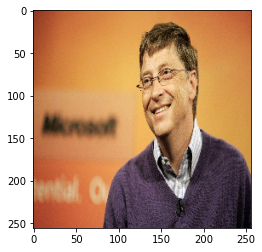

In [27]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image

path = "../input/potraitimages/pics/billgates.jpg"
img= cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(256,256))
plt.imshow(img)


im = Image.fromarray(img)
im.save("input.jpeg")

In [28]:
def read_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    return img

In [29]:
def prediction(path):
    img=read_image(path)
    img=img.reshape(1,256,256,3)
    pred=segnet_trained.predict(img)
    pred=pred.reshape(256,256)
    pre=pred>0.5
    pre=pre.astype(int)
    ind=np.where(pre==0)
    img=img.reshape((256,256,3))
    m=img.copy()
    m[ind[0],ind[1],:]=255
    return img,m

In [30]:
a,b=prediction("../input/potraitimages/pics/billgates.jpg")

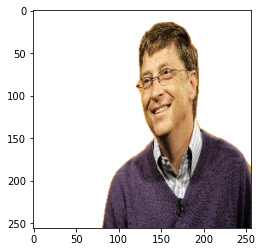

In [31]:
plt.imshow(b)
from PIL import Image
im = Image.fromarray(b)
im.save("b.jpeg")

In [32]:
img=read_image(path)
img=img.reshape(1,256,256,3)
pred=segnet_trained.predict(img)

In [33]:
type(pred)

numpy.ndarray

In [34]:
pred.shape

(1, 256, 256, 1)

In [35]:
pred=pred.reshape(256,256)

In [36]:
pred.shape

(256, 256)

In [37]:
pred = pred>.5

In [38]:
type(pred[0][0])

numpy.bool_

In [39]:
x = pred.astype(int)

In [40]:
ind=np.where(x==0)

In [41]:
ind

(array([  0,   0,   0, ..., 255, 255, 255]),
 array([ 0,  1,  2, ..., 78, 79, 80]))

In [42]:
type(ind)

tuple

In [43]:
len(list(ind[0]))

40841

In [44]:
img=read_image(path)


In [45]:
img=read_image(path)
img=img.reshape(1,256,256,3)
pred=segnet_trained.predict(img)
pred=pred.reshape(256,256)
img=img.reshape((256,256,3))

In [46]:
x = np.zeros(( 256,256), dtype=np.float)
f = np.zeros((256,256,4),np.uint8)
f[:,:,:4] = img.copy()
x = pred > 0.5
f[:,:,3] = pred*255
plt.imshow(f)
print(type(f[:,:,3]))

ValueError: could not broadcast input array from shape (256,256,3) into shape (256,256,4)

In [47]:
from PIL import Image

img = Image.open('./b.jpeg')
img = img.convert("RGBA")

imgnp = np.array(img)

white = np.sum(imgnp[:,:,:3], axis=2)
white_mask = np.where(white == 255*3, 1, 0)

alpha = np.where(white_mask, 0, imgnp[:,:,-1])

imgnp[:,:,-1] = alpha 

img = Image.fromarray(np.uint8(imgnp))
img.save("tb2.png", "PNG")

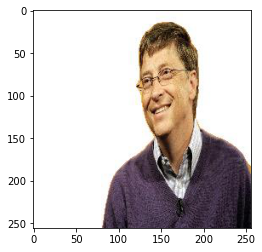

In [48]:
plt.imshow(img)